# Predicting Tourists Arrivals at Pistoia
This notebook describes how to predict a variable sinusoid in Python.

Data analysed: Data ar extracted from https://turismo5pistoia.regione.toscana.it/ through a scraper. Data are updated to April 2020.


In [1]:
import pandas as pd
df = pd.read_csv('data/arrivals_pistoia.csv')

df

Year  Month  Arrivals
0   2012      1     14751
1   2012      2     18562
2   2012      3     41478
3   2012      4     55215
4   2012      5     53843
..   ...    ...       ...
94  2019     11     47747
95  2019     12     40886
96  2020      1     36281
97  2020      2     33587
98  2020      3      4766

[99 rows x 3 columns]

## Preliminary analysis
We plot `y` to understand the trendline. We build the auxiliary vector `X`, which contains all the months. Month 0 refers to 2012 Genuary. In order to display x labels in the graph every year, we build two auxiliary variables, `x_ticks` and `x_labels`.

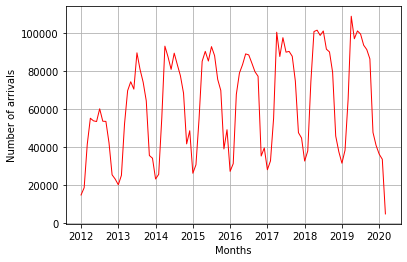

In [2]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

y = []
for i in range(0, len(df['Arrivals'])):
    y.append(df['Arrivals'][i])
X = np.arange(0, len(y))

step = 1
x_ticks = np.arange(0, len(y)+step, step=12*step)
x_labels = []
x_labels.append(2012)
for i in range(1, len(x_ticks)+1):
    x_labels.append(x_labels[i-1]+step)
plt.xticks(x_ticks, x_labels)
plt.plot(X, y, color="red", linewidth=1)

plt.grid()
plt.xlabel('Months')
plt.ylabel('Number of arrivals')

plt.show()

## Data approximation
Now we can approximate data with a sinusoid. The equation of a sinusoid is `A*np.sin(omega*x+phase) + offset`, where:
* |`A`| indicates the amplitude, i.e. half the distance between the maximum and minimum values of the function
* `omega` is the number of cycles between 0 and 2pi. The period T is 2pi/omega
* `phase` is the horizontal shift
* `offset` is the vertical shift, i.e. the sum between the minimum peak and the amplitude. Here some details about offset: https://www.ck12.org/book/ck-12-precalculus-concepts/section/5.4/

For more details about sinusoids, you can give a look at: https://mathbitsnotebook.com/Algebra2/TrigGraphs/TGsinusoidal.html

In [3]:
def sinusoid(x,A,offset,omega,phase):
    return A*np.sin(omega*x+phase) + offset

We define also initial values for the sinusoid. We set the period `T = 12`, i.e. the number of months in a year. If the period is not known, we should calculate it. We could use the Fast Fourier Transform. At these links you can find more details about this aspect: https://stackoverflow.com/questions/16716302/how-do-i-fit-a-sine-curve-to-my-data-with-pylab-and-numpy, https://www.oreilly.com/library/view/elegant-scipy/9781491922927/ch04.html and https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fft.html.

In [4]:
T = 12
def get_p0(x, y):
    
    A0 = (max(y[0:T]) - min(y[0:T]))/2
    offset0 = y[0]
    phase0 = 0
    omega0 = 2.*np.pi/T
    return [A0, offset0,omega0, phase0]

Now we are ready to approximate our data with a sinusoid. We use the `curve_fit()` function provided by `scipy`. The we plot results. For more details about the `curve_fit()` function, please give a look at https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html.

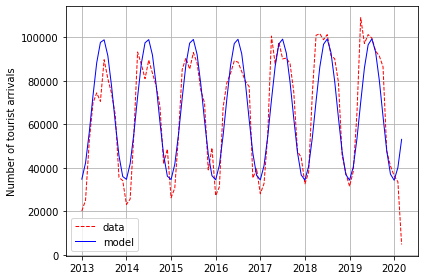

In [5]:
from scipy.optimize import curve_fit
import math

skip = 12
X = X[skip:]
y = y[skip:]

param, covariance = curve_fit(sinusoid, X, y, p0=get_p0(X,y))
step = 1
x_ticks = np.arange(skip, skip+len(X)+step+12, step=12*step)
x_labels = []
x_labels.append(2013)
for i in range(1, len(x_ticks)+13):
    x_labels.append(x_labels[i-1]+step)
plt.xticks(x_ticks, x_labels)
plt.ylabel('Number of tourist arrivals')
plt.plot(X, y, color="red", linewidth=1,linestyle='dashed', label="data")
plt.plot(X, sinusoid(X, *param), color="blue", linewidth=1, label="model")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("plots/sinusoid_PT.png")
plt.show()

We have approximated our data with a sinusoid with a constant value of `A`. In our case both the amplitude `A` and the `offset` are variable. The idea is to calculate all the maximum peaks and minimum peaks in our data. Then we can use their difference to calculate the vector of amplitudes and pass them to the `sinusoid()` function.

We define the function `get_peaks()`, which calculates the peaks of an array. We sample the array every `T` elements and we calculate the peak within each `T`.

In [6]:
def get_peaks(y, metrics):
    n = int(math.ceil(len(y)/T))
    step = 0
    x_peaks = []
    y_peaks = []
    for i in range(0,n):
        peak_index = y.index(metrics(y[step:step+T]))
        x_peaks.append(peak_index + skip)
        y_peaks.append(y[peak_index])
        step = step+T
    return [x_peaks,y_peaks]

We calculate the maximum and minimum peaks.

In [7]:
# approximate curve of peaks with
min_peaks = get_peaks(y,min)
max_peaks = get_peaks(y,max)

Now we can calculate the array of amplitudes and offsets.

In [8]:
#calculate variable amplitude and variable offset
A = []
offset = []
for i in range(0, len(min_peaks[1])):
    c_a = (max_peaks[1][i] - min_peaks[1][i])/2
    c_offset = min_peaks[1][i] + c_a
    for j in range(0,T):
        A.append(c_a)
        offset.append(c_offset)
# last two months of 2019 are not available
A = A[:-9]
offset = offset[:-9]

Since `A` and `offset` are new features, we should add them as variables. Thus we define a new variable `features`, which defines the new input features of our model. Then we define the function `variable_sinusoid()`, which takes the features as input. 

The only parameters returned by our model are `omega` and `phase` thus we modify also the function `get_p0()` with initial values of `omega` and `phase`. The new function is called `variable_get_p0()`.

In [9]:
features = [X, A, offset]

cut = 4
features_c = [X[:-cut], A[:-cut], offset[:-cut]]
y_c = y[:-cut]
X_c = X[:-cut]
def variable_sinusoid(f,omega,phase):
    x = f[0]
    A = f[1]
    offset = f[2]
    return A*np.sin(omega*x+phase) + offset

def variable_get_p0(x, y): 
    phase0 = 0
    omega0 = 2.*np.pi/T
    return [omega0, phase0]

We fit the model and plot results.

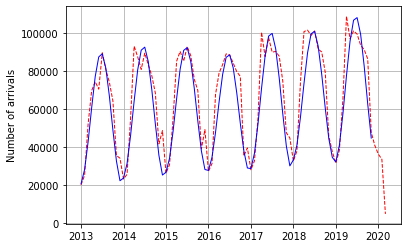

In [10]:
param, covariance = curve_fit(variable_sinusoid, features_c, y_c, p0=variable_get_p0(X_c,y_c))

plt.xticks(x_ticks, x_labels)
plt.ylabel('Number of arrivals')
plt.plot(X, y, color="red", linewidth=1,linestyle='dashed')
plt.plot(X_c, variable_sinusoid(features_c, *param), color="blue", linewidth=1)
plt.grid()
plt.show()

In [11]:
#perr = np.sqrt(np.diag(covariance))
y_pred = variable_sinusoid(features, *param)
residuals = y - y_pred
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y-np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)
r_squared
#y_pred = variable_sinusoid(features, *param)
#RMSE = np.sqrt(np.sum((y_pred - y)**2)/n)
#RMSE

0.7854909005944601

In [12]:
from scipy import stats
z_score_it = stats.zscore(y)
z_score_pt = stats.zscore(y_pred)
stats.pearsonr(y_pred, y) 

(0.9202991661223768, 2.12068639478379e-36)

## Predicting the future trendline
The next step involves the prediction of the next sinusoid, i.e. the sinusoid for year 2020. In order to do it, we need to calculate the next max and minimum peaks. We can do it by approximating the vector of maximum and minimum peaks with two linear regressions, respectively. Then, we can calculate the maximum peak at instant i (August 2020) as the y value of the maximum linear regression given at instant (i-1) + pi (i-1 represents August 2019). Similarly, we can calculate the minimum peak for year 2020.

Firstly, we reshape the peaks to be passed to the linear model. Then, we build two linear models, one for each predicting line, using the `sklearn` class `LinearRegression()`. After that, we fit every model using the `fit()` function.

In [13]:
from sklearn import linear_model

# approximate curve of peaks with
min_peaks = get_peaks(y_c,min)
max_peaks = get_peaks(y_c,max)

# reshape x_peaks
x_min_peaks = list(map(lambda el:[el], min_peaks[0])) 
x_max_peaks = list(map(lambda el:[el], max_peaks[0]))



# min model
model_min = linear_model.LinearRegression()
model_min.fit(x_min_peaks,min_peaks[1])

# max model
model_max = linear_model.LinearRegression()
model_max.fit(x_max_peaks,max_peaks[1])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

We append the next peaks both to `x_max_peaks` and `x_min_peaks` and then we predict the maximum and minimum peaks through the `predict()` function.

In [14]:
x_min_peaks.append([x_min_peaks[len(x_min_peaks) -1][0] + T])
x_max_peaks.append([x_max_peaks[len(x_max_peaks) -1][0] + T])
y_pred_min = model_min.predict(x_min_peaks)
y_pred_max = model_max.predict(x_max_peaks)

In [15]:
stats.pearsonr(y_pred_min[:-1], min_peaks[1]) 

(0.9642616839291615, 0.0004549075619139592)

In [16]:
stats.pearsonr(y_pred_max[:-1], max_peaks[1]) 

(0.8543343908841297, 0.014357748045269247)

We plot the two predicting lines.

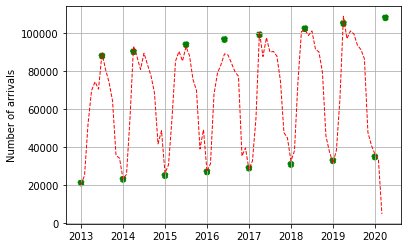

In [17]:
plt.xticks(x_ticks, x_labels)
plt.plot(X, y, color="red", linewidth=1,linestyle='dashed')
plt.scatter(x_min_peaks, y_pred_min, color="green", linewidth=1,linestyle='dashed')
plt.scatter(x_max_peaks, y_pred_max, color="green", linewidth=1,linestyle='dashed')
plt.ylabel('Number of arrivals')
plt.grid()
plt.show()

We calculate the sinusoid for all the period, including 2020. We build a variable `X_pred`, which contains `X` and the 12 months of 2020.

In [18]:
X_pred = np.array(X_c)
month = X_pred[len(X_pred)-1] + 1
mp = 5
for i in range(1,mp):
    X_pred = np.append(X_pred,month)
    month = month + 1

Now, we can update the variable `features_pred` to be passed to the `variable_sinusoid()` function. Firstly, we update the amplitude `A` and the `offset` with new values and then we update the `features_pred` variable.

In [19]:
index = len(max_peaks[0])-1
c_a = (max_peaks[1][index] - min_peaks[1][index])/2
c_offset = min_peaks[1][index] + c_a

A_c = list(A[:-cut])
offset_c = list(offset[:-cut])
for j in range(1,mp):
        A_c.append(c_a)
        offset_c.append(c_offset)

features_pred = [X_pred, A_c, offset_c]
print(len(X_pred))
print(len(A_c))

87
87


Finally, we plot graphs.

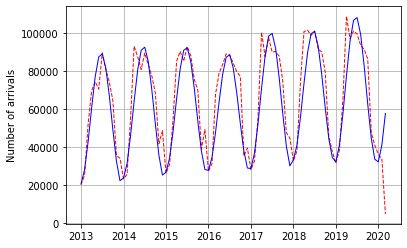

In [20]:
plt.xticks(x_ticks, x_labels)
plt.plot(X, y, color="red", linewidth=1,linestyle='dashed')
plt.plot(X_pred, variable_sinusoid(features_pred, *param), color="blue", linewidth=1)
plt.grid()
plt.ylabel('Number of arrivals')
plt.savefig("plots/sinusoid_pt.png")
plt.show()

# Calculate difference
Now we calculate the difference between real values (due to COVID-19) and predicted values. This difference will be used to predict real values for Italy.

In [21]:
mp = 0
#A = np.array(y[len(y)-mp:]) # valore reale
A = np.array(y)
A[23]

48637

In [22]:
B = variable_sinusoid(features_pred, *param) # valore predetto
#B = B[len(B)-mp:]
B[23]

25267.84620756453

In [23]:
# the sum of absolute differences (SAD), the sum of squared differences (SSD) or the correlation coefficient:
print( "SAD:", np.sum(np.abs(A - B)))
print ("SSD:", np.sum(np.square(A - B)))
print ("correlation:", np.corrcoef(np.array((A, B)))[0, 1])
# calcolo la varizione percentuale (valore finale - valore iniziale)/valore iniziale
perc = (A-B)/B*100
#perc = A-B
# nel mese di dicembre c'è un piccolo picco (dovuto al turismo invernale), per cui il mio sistema commette un errore
# non considero questi picchi per il calcolo degli errori

errors = []
for i in range(1,len(perc)-3):
    if i%12 != 0:
        errors.append(perc[i-1])
max_error = max(errors)

max_perc = perc[len(perc)-3:] + max_error
min_perc = perc[len(perc)-3:] - max_error
print(perc[len(perc)-3:])
print(max_perc)
print(min_perc)

SAD: 759559.5738275202
SSD: 14009348509.47855
correlation: 0.896585854322301
[ 12.55063004 -18.26957259 -91.75074666]
[ 59.66783167  28.84762904 -44.63354503]
[ -34.56657159  -65.38677422 -138.8679483 ]


We also export predictions to a CSV file.

In [24]:
import csv

table = []
y_pred = variable_sinusoid(features_pred, *param)
for i in range(0, len(X_pred)):
    row = { 'x' : X_pred[i], 'y' : y_pred[i]}
    table.append(row)

names = table[0].keys()
with open('data/pistoia_arrivals_prediction.csv', 'w') as output_file:
    dict_writer = csv.DictWriter(output_file, names)
    dict_writer.writeheader()
    dict_writer.writerows(table)